# Regression & Bayesian Analysis with Food Deserts
## Part 1: Exploratory Analysis and Getting Data into Shape

______
## Key Terms
 * ### Food desert: 
     - A census tract that meets both low-income and low-access criteria including: 1. poverty rate is greater than or equal to 20 percent OR median family income does not exceed 80 percent statewide (rural/urban) or metro-area (urban) median family income; 2. at least 500 people or 33 percent of the population located more than 1 mile (urban) or 10 miles (rural) from the nearest supermarket or large grocery store.  
 * ### Low-income area
     - A tract in which the poverty rate is greater than or equal to 20 percent; or in which median family income does not exceed 80 percent of the statewide or metro-area median family income. This definition of low-income tracts is used to designate tracts that are eligible for the U.S. Department of the Treasury’s New Markets Tax Credit (NMTC) program.
 * ### Low-income household: 
     - A household with income less than the Federal poverty level : 17,050 dollars for a family of four in 2000.
 * ### Rural area: 
      - Includes areas defined by Rural-Urban Commuting Area codes as large rural, small rural, and isolated rural areas.
      
      
http://www.ers.usda.gov/media/883903/err140.pdf

The above definitions were defined in http://www.ers.usda.gov/media/883903/err140.pdf 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Loading Original Dataset and Initial Cleaning

First lets read in our data, which can be downloaded from http://www.ers.usda.gov/data-products/food-access-research-atlas/download-the-data.aspx under the Current Version heading. 

In [37]:
df=pd.read_excel('/Users/workspace/PycharmProjects/desert/desert_data/food_desert.xlsx',sheetname=2)
cols = df.columns.tolist()

For reference, lets also read in the column meanings which are contained in the excel file. 

For convience we can also make  a dictionary from our desert_vars dataframe that provides us with a means to quickly look up column name meanings. This dictionary is made below, and named col_dict


In [38]:
#desert data variables 
desert_vars=pd.read_excel('/Users/workspace/PycharmProjects/desert/desert_data/food_desert.xlsx',sheetname=1)

# provides us with a dictionary to quickly look up column name meanings
col_dict = desert_vars.set_index('Field').to_dict()['LongName']

# reformats our dataframe for ease of use, to look up variable use .loc (desert_vars.loc['LongName','LILATracts_1And10'])
desert_vars=desert_vars.T
desert_vars.columns = list(desert_vars.loc['Field'])
desert_vars.head()

,CensusTract,County,GroupQuartersFlag,HUNVFlag,LA1and10,LA1and20,LAhalfand10,lahunv1,lahunv10,lahunv10share,...,LILATracts_Vehicle,LowIncomeTracts,NUMGQTRS,OHU2010,PCTGQTRS,POP2010,Rural,State,UATYP10,Urban
Field,CensusTract,County,GroupQuartersFlag,HUNVFlag,LA1and10,LA1and20,LAhalfand10,lahunv1,lahunv10,lahunv10share,...,LILATracts_Vehicle,LowIncomeTracts,NUMGQTRS,OHU2010,PCTGQTRS,POP2010,Rural,State,UATYP10,Urban
LongName,Census tract,County,"Group quarters, tract with high share","Vehicle access, tract with low rate",Low access tract at 1 mile for urban areas or ...,Low access tract at 1 mile for urban areas or ...,Low access tract at 1/2 mile for urban areas o...,"Vehicle access, housing units without and low ...","Vehicle access, housing units without and low ...","Vehicle access, percentage of housing units wi...",...,Low income and low access using vehicle access,Low income tract,"Group quarters, tract population residing in, ...","Housing units, total","Group quarters, tract population residing in, ...","Population, tract total",Rural tract,State,Census urban area,Urban tract


In [39]:
desert_vars.loc['LongName','LILATracts_1And10']
desert_vars.loc['LongName','lalowi10']

u'Low access, low-income people at 10 miles, number'

Before moving forward, lets take a look at our dataset by making a correlation matrix. This will allow us to see what variables it contains, and the correlations that exist amongst our variables.

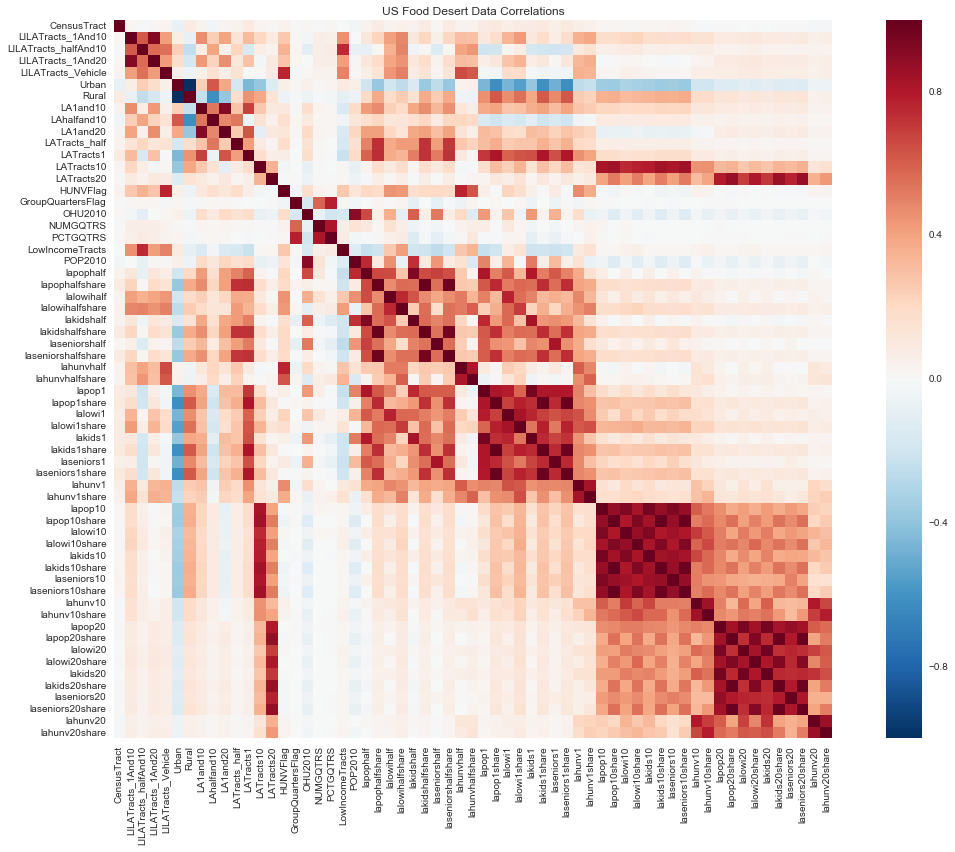

In [5]:
# Load the datset correlations
corrmat = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('US Food Desert Data Correlations')
f.tight_layout()

Let's organize our dataset by county. This will allow us to compare the prevelance of food deserts in different counties. We can accomplish this by performing some data munging with pandas. 

In [40]:

def calculate_effected(s):
    a = s['lalowi1'] / s['POP2010'] 
    b = s['lalowi10'] / s['POP2010']
    if a >= b:
        return pd.Series({'perc_effected': a})
    else:
        return pd.Series({'perc_effected': b})

#Drops invalid rows.
df = df[df['POP2010'] != 0]
    
# Obtains the percentage of Censustract residents living in low access/low income areas.
fd = df[['CensusTract','lalowi10','lalowi1','POP2010']]
fd = fd.merge(fd.apply(calculate_effected, axis=1), left_index=True, right_index=True)
fd = fd[['CensusTract','perc_effected']]
df = pd.merge(df,fd,how='left',on='CensusTract').fillna(0.0)

# Obtains county level average percentages of the number of residents living in low access/low income areas.
fd = df.groupby(['State','County']).agg(np.mean)['perc_effected'].reset_index()

In [41]:

def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 


# Obtains the number of census tracts per county
num_county_tracts=df.groupby(['State','County']).count()['CensusTract'].reset_index()
num_county_tracts.rename(columns={'CensusTract':'n_tracts'}, inplace=True)

# Obtains county level sums for the vaules we wish to examine.
us = df.groupby(['State','County']).sum()[['POP2010','Urban','Rural','LowIncomeTracts','HUNVFlag','LILATracts_1And10','OHU2010', 'NUMGQTRS', 'lalowi1','lalowi10']]#.astype(int)
us = pd.merge(us.reset_index(), num_county_tracts, how='inner', on=['State','County'])
us = pd.merge(us, fd, how='inner', on=['State','County'])
us=us.set_index(['State','County'])


us['pop_effected'] = us['perc_effected'] * us['POP2010']
us['pop_effected'] = us['pop_effected'].map(lambda x : int(round(x)))
us['des_percent'] = us['LILATracts_1And10'] / us['n_tracts']
#us.rename(columns={'LILATracts_1And10':'food_deserts', 'OHU2010':'total_housing_units','NUMGQTRS':'pop_in_group_housing', 'HUNVFlag':'low_vehicle_tracts','Urban':'n_urban', 'Rural':'n_rural','lalowi1':'pop_1mile','lalowi10':'pop_10mile'}, inplace=True)

us.head(2)

POP2010  Urban  Rural  LowIncomeTracts  HUNVFlag  \
State County                                                             
AK    Aleutians East     3141      0      1                1         1   
      Aleutians West     5561      0      2                1         0   

                      LILATracts_1And10  OHU2010  NUMGQTRS      lalowi1  \
State County                                                              
AK    Aleutians East                  1      553    1726.0  1235.612066   
      Aleutians West                  1     1212    2543.0  1569.045516   

                        lalowi10  n_tracts  perc_effected  pop_effected  \
State County                                                              
AK    Aleutians East  699.718961         1       0.393382          1236   
      Aleutians West  400.743202         2       0.307364          1709   

                      des_percent  
State County                       
AK    Aleutians East          1.0  
      Aleutians West          0.5

In [42]:
us = us.reset_index()

# Creates our CA county level dataframe
ca = us[us['State']=='CA']
ca = ca.drop(['lalowi10','lalowi1'],axis=1)
ca = order(ca,['State','County','POP2010','perc_effected','n_tracts','des_percent'])
ca.head(2)

,State,County,POP2010,perc_effected,n_tracts,des_percent,Urban,Rural,LowIncomeTracts,HUNVFlag,LILATracts_1And10,OHU2010,NUMGQTRS,pop_effected
186,CA,Alameda,1510271,0.018032,360,0.041667,354,6,153,53,15,545138,37442.0,27233
187,CA,Alpine,1175,0.266288,1,0.000000,0,1,0,0,0,497,24.0,313


In [45]:
ca_count_totals = ca[['POP2010','n_tracts']].sum(axis=0)
ca_count_totals.ix['POP2010']
ca['state_pop_ratio'] = ca['POP2010'] / ca_count_totals.ix['POP2010'] 
ca['state_tract_ratio']=ca['n_tracts'] / ca_count_totals.ix['n_tracts']
ca.head()

,State,County,POP2010,perc_effected,n_tracts,des_percent,Urban,Rural,LowIncomeTracts,HUNVFlag,LILATracts_1And10,OHU2010,NUMGQTRS,pop_effected,state_pop_ratio,state_tract_ratio
186,CA,Alameda,1510271,0.018032,360,0.041667,354,6,153,53,15,545138,37442.0,27233,0.040540,0.044865
187,CA,Alpine,1175,0.266288,1,0.000000,0,1,0,0,0,497,24.0,313,0.000032,0.000125
188,CA,Amador,38091,0.149514,9,0.000000,0,9,2,2,0,14569,4551.0,5695,0.001022,0.001122
189,CA,Butte,220000,0.145583,51,0.274510,38,13,32,13,14,87618,4942.0,32028,0.005905,0.006356
190,CA,Calaveras,45578,0.203345,10,0.000000,2,8,2,1,0,18886,493.0,9268,0.001223,0.001246


In [27]:
# # Obtains the number of census tracts per county
# num_county_tracts=df.groupby('County').count()['CensusTract'].reset_index()

# # Obtains the total number of food deserts. Technically defined in column LILATracts_1And10,
# # but totals for alternative definitions of food deserts are also obtained by including
# # 'LILATracts_halfAnd10','LILATracts_1And20', and 'LILATracts_Vehicle'.
# county_sums = df.groupby('County').agg(np.sum)['LILATracts_1And10'].reset_index()
# county_df = pd.merge(num_county_tracts,county_sums,how='inner', on='County')

# county_df['des_percent'] = county_df['LILATracts_1And10'] / county_df['CensusTract'] 

# county_df['high_food_des_prev'] = county_df['des_percent'] > 0.272727
# county_df['high_food_des_prev'] = county_df['high_food_des_prev'].astype(int)
# county_df=county_df[['County','high_food_des_prev']]
# df = pd.merge(df,county_df,how='inner',on='County')
# df.head()

Next we will restrict our original dataset to counties located in California.

In [47]:
subset = ['CensusTract','State','County','HUNVFlag','NUMGQTRS','OHU2010','POP2010','Rural','Urban','LILATracts_1And10']
df = df[df['State']=='CA']
df=df[subset]
df.head()

# Obtains the counts of urban and rural tracts that are considered food deserts
urban_rural = df[df['LILATracts_1And10'] == 1].groupby('County').agg(np.sum).reset_index()[['County','Urban','Rural']]
urban_rural.rename(columns={'Urban':'urban_des','Rural':'rural_des'}, inplace=True)
urban_rural
ca = pd.merge(ca,urban_rural, how='left', on='County')
ca=ca.fillna(0)
ca


,State,County,POP2010,perc_effected,n_tracts,des_percent,Urban,Rural,LowIncomeTracts,HUNVFlag,LILATracts_1And10,OHU2010,NUMGQTRS,pop_effected,state_pop_ratio,state_tract_ratio,urban_des,rural_des
0,CA,Alameda,1510271,0.018032,360,0.041667,354,6,153,53,15,545138,37442.0,27233,0.040540,0.044865,15.0,0.0
1,CA,Alpine,1175,0.266288,1,0.000000,0,1,0,0,0,497,24.0,313,0.000032,0.000125,0.0,0.0
2,CA,Amador,38091,0.149514,9,0.000000,0,9,2,2,0,14569,4551.0,5695,0.001022,0.001122,0.0,0.0
3,CA,Butte,220000,0.145583,51,0.274510,38,13,32,13,14,87618,4942.0,32028,0.005905,0.006356,13.0,1.0
4,CA,Calaveras,45578,0.203345,10,0.000000,2,8,2,1,0,18886,493.0,9268,0.001223,0.001246,0.0,0.0
5,CA,Colusa,21419,0.127574,5,0.200000,2,3,3,0,1,7056,225.0,2733,0.000575,0.000623,1.0,0.0
6,CA,Contra Costa,1049025,0.037477,207,0.072464,202,5,65,30,15,375364,10314.0,39314,0.028159,0.025798,15.0,0.0
7,CA,Del Norte,28610,0.258870,7,0.428571,4,3,5,2,3,9907,3818.0,7406,0.000768,0.000872,2.0,1.0
8,CA,El Dorado,181058,0.103227,42,0.071429,20,22,6,3,3,70223,1643.0,18690,0.004860,0.005234,2.0,1.0
9,CA,Fresno,930450,0.106664,199,0.155779,170,29,119,44,31,289391,17523.0,99246,0.024976,0.024801,26.0,5.0


Below adds county level data obtained from the CDC which includes the prevelance of obesity, diabetes, and inactivity in CA counties. The function reformat_cdc_file cleans these files so that only the 2010 values are returned. We also subset our data to only CA prior to merging this data with our original dataframe.

In [53]:
#http://www.cdc.gov/diabetes/data/countydata/countydataindicators.html
obese=pd.read_excel('/Users/workspace/food_desert_data/California (1).xlsx',sheet=1,header=1)#,header=[1,2])
dm=pd.read_excel('/Users/workspace/food_desert_data/desert_data/California_diabetes_rates.xlsx',sheet=1,header=1)#,header=[1,2])
inactive=pd.read_excel('/Users/workspace/food_desert_data/desert_data/inactivity_ca.xlsx',sheet=1,header=1)#,header=[1,2])

def reformat_cdc_file(frame, col_names):
    cols = frame.columns.tolist()
    keep = cols[45:52]
    keep.append(cols[2])
    frame=frame[keep]
    frame.columns = list(frame.T[0].values)
    frame = frame[1:]
    frame.rename(columns={'Number':'fips'}, inplace=True)
    frame = frame[['Percent','Age-adjusted Percent','County']]
    frame.columns = col_names
    frame['County']=frame['County'].replace(to_replace=' County', value="",regex=True)
    return frame

obese=reformat_cdc_file(obese,['cnty_obesity_pct','cnty_obesity_pct_adj','County'])
dm=reformat_cdc_file(dm,['cnty_dm_pct','cnty_dm_pct_adj','County'])
inactive =reformat_cdc_file(inactive,['cnty_inactive_pct','cnty_inactive_pct_adj','County'])

cdc=pd.merge(obese,dm,how='inner',on='County')
cdc=pd.merge(cdc,inactive,how='inner',on='County')
cdc = cdc.apply(lambda x: pd.to_numeric(x, errors='ignore')) 
cdc.dtypes
percents = [c for c in cdc.columns.tolist() if c != 'County']
cdc[percents] = cdc[percents].apply(lambda x: x / 100)
keep=['County','cnty_obesity_pct_adj','cnty_dm_pct_adj','cnty_inactive_pct_adj']

ca = pd.merge(ca,cdc[keep],how='inner',on='County')

ca.head()


,State,County,POP2010,perc_effected,n_tracts,des_percent,Urban,Rural,LowIncomeTracts,HUNVFlag,...,OHU2010,NUMGQTRS,pop_effected,state_pop_ratio,state_tract_ratio,urban_des,rural_des,cnty_obesity_pct_adj,cnty_dm_pct_adj,cnty_inactive_pct_adj
0,CA,Alameda,1510271,0.018032,360,0.041667,354,6,153,53,...,545138,37442.0,27233,0.040540,0.044865,15.0,0.0,0.204,0.078,0.161
1,CA,Alpine,1175,0.266288,1,0.000000,0,1,0,0,...,497,24.0,313,0.000032,0.000125,0.0,0.0,0.232,0.077,0.173
2,CA,Amador,38091,0.149514,9,0.000000,0,9,2,2,...,14569,4551.0,5695,0.001022,0.001122,0.0,0.0,0.228,0.075,0.158
3,CA,Butte,220000,0.145583,51,0.274510,38,13,32,13,...,87618,4942.0,32028,0.005905,0.006356,13.0,1.0,0.243,0.073,0.163
4,CA,Calaveras,45578,0.203345,10,0.000000,2,8,2,1,...,18886,493.0,9268,0.001223,0.001246,0.0,0.0,0.253,0.067,0.161


In [54]:
ca = ca.apply(lambda x: pd.to_numeric(x, errors='ignore'))  # Convert columns to numeric where possible
ca.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 21 columns):
State                    58 non-null object
County                   58 non-null object
POP2010                  58 non-null int64
perc_effected            58 non-null float64
n_tracts                 58 non-null int64
des_percent              58 non-null float64
Urban                    58 non-null int64
Rural                    58 non-null int64
LowIncomeTracts          58 non-null int64
HUNVFlag                 58 non-null int64
LILATracts_1And10        58 non-null int64
OHU2010                  58 non-null int64
NUMGQTRS                 58 non-null float64
pop_effected             58 non-null int64
state_pop_ratio          58 non-null float64
state_tract_ratio        58 non-null float64
urban_des                58 non-null float64
rural_des                58 non-null float64
cnty_obesity_pct_adj     58 non-null float64
cnty_dm_pct_adj          58 non-null float64
cnty_inactive_pct

In [55]:
ca.head()

,State,County,POP2010,perc_effected,n_tracts,des_percent,Urban,Rural,LowIncomeTracts,HUNVFlag,...,OHU2010,NUMGQTRS,pop_effected,state_pop_ratio,state_tract_ratio,urban_des,rural_des,cnty_obesity_pct_adj,cnty_dm_pct_adj,cnty_inactive_pct_adj
0,CA,Alameda,1510271,0.018032,360,0.041667,354,6,153,53,...,545138,37442.0,27233,0.040540,0.044865,15.0,0.0,0.204,0.078,0.161
1,CA,Alpine,1175,0.266288,1,0.000000,0,1,0,0,...,497,24.0,313,0.000032,0.000125,0.0,0.0,0.232,0.077,0.173
2,CA,Amador,38091,0.149514,9,0.000000,0,9,2,2,...,14569,4551.0,5695,0.001022,0.001122,0.0,0.0,0.228,0.075,0.158
3,CA,Butte,220000,0.145583,51,0.274510,38,13,32,13,...,87618,4942.0,32028,0.005905,0.006356,13.0,1.0,0.243,0.073,0.163
4,CA,Calaveras,45578,0.203345,10,0.000000,2,8,2,1,...,18886,493.0,9268,0.001223,0.001246,0.0,0.0,0.253,0.067,0.161


In [56]:
# # Checks how many counties are in CA
# len(df[df['State']=='CA']['County'].unique()) # 58 counties in CA

# # Obtains the number of census tracts per county
# num_county_tracts=df.groupby('County').count()['CensusTract'].reset_index()

# # Obtains the total number of food deserts. Technically defined in column LILATracts_1And10,
# # but totals for alternative definitions of food deserts are also obtained by including
# # 'LILATracts_halfAnd10','LILATracts_1And20', and 'LILATracts_Vehicle'.
# county_sums = df.groupby('County').agg(np.sum)[['LILATracts_1And10','Urban','Rural']].reset_index()

# # df containing totals for each county
# county_df = pd.merge(num_county_tracts,county_sums,how='inner', on='County')
# county_df.rename(columns={'CensusTract':'num_tracts','Urban':'n_urban', 'Rural': 'n_rural','LILATracts_1And10': 'n_food_des'}, inplace=True)

# # # Normalize for county size by obtaining percentages
# county_df



After taking a quick look at our dataset, we can see our transformations have left us with some NaN values. By looking at the variables we defined above, we can see that these values should be filled with 0's. This is accomplished by executing the cell below.

This type of data preparation can be messy, so it is important that we validate our dataset throughout this process. Before moving forward, lets ensure we still have the correct number of counties in our dataset (58). 

In [57]:
print len(ca['County'].unique())
#ca
a=[c for c in ca.columns.tolist()]
b=[c for c in df.columns.tolist()]
ab = [c for c in b if c not in a]
ab

58


[u'CensusTract']

Great! Now let's merge our county dataframe with our original dataset.

In [58]:
df=ca#pd.merge(ca,df[['County','CensusTract']],how='inner',on='County')#.set_index('County')
df.rename(columns={'LILATracts_1And10':'food_deserts', 'OHU2010':'total_housing_units','NUMGQTRS':'pop_in_group_housing', 'HUNVFlag':'low_vehicle_tracts','Urban':'n_urban', 'Rural':'n_rural', 'perc_effected':'perc_lali'}, inplace=True)
#ca.rename(columns={'LILATracts_1And10':'food_deserts', 'OHU2010':'total_housing_units','NUMGQTRS':'pop_in_group_housing', 'HUNVFlag':'low_vehicle_tracts','Urban':'n_urban', 'Rural':'n_rural'}, inplace=True)

df.head()

,State,County,POP2010,perc_lali,n_tracts,des_percent,n_urban,n_rural,LowIncomeTracts,low_vehicle_tracts,...,total_housing_units,pop_in_group_housing,pop_effected,state_pop_ratio,state_tract_ratio,urban_des,rural_des,cnty_obesity_pct_adj,cnty_dm_pct_adj,cnty_inactive_pct_adj
0,CA,Alameda,1510271,0.018032,360,0.041667,354,6,153,53,...,545138,37442.0,27233,0.040540,0.044865,15.0,0.0,0.204,0.078,0.161
1,CA,Alpine,1175,0.266288,1,0.000000,0,1,0,0,...,497,24.0,313,0.000032,0.000125,0.0,0.0,0.232,0.077,0.173
2,CA,Amador,38091,0.149514,9,0.000000,0,9,2,2,...,14569,4551.0,5695,0.001022,0.001122,0.0,0.0,0.228,0.075,0.158
3,CA,Butte,220000,0.145583,51,0.274510,38,13,32,13,...,87618,4942.0,32028,0.005905,0.006356,13.0,1.0,0.243,0.073,0.163
4,CA,Calaveras,45578,0.203345,10,0.000000,2,8,2,1,...,18886,493.0,9268,0.001223,0.001246,0.0,0.0,0.253,0.067,0.161


In [59]:
df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 0 to 57
Data columns (total 21 columns):
State                    58 non-null object
County                   58 non-null object
POP2010                  58 non-null int64
perc_lali                58 non-null float64
n_tracts                 58 non-null int64
des_percent              58 non-null float64
n_urban                  58 non-null int64
n_rural                  58 non-null int64
LowIncomeTracts          58 non-null int64
low_vehicle_tracts       58 non-null int64
food_deserts             58 non-null int64
total_housing_units      58 non-null int64
pop_in_group_housing     58 non-null float64
pop_effected             58 non-null int64
state_pop_ratio          58 non-null float64
state_tract_ratio        58 non-null float64
urban_des                58 non-null float64
rural_des                58 non-null float64
cnty_obesity_pct_adj     58 non-null float64
cnty_dm_pct_adj          58 non-null float64
cnty_inactive_pct

In [60]:
#order(df, ['S'])
print df.columns.tolist()
df = order(df,['State', 'County', u'POP2010','food_deserts','n_tracts',  'urban_des', 'rural_des','n_urban', 'n_rural','des_percent'])


['State', 'County', u'POP2010', 'perc_lali', 'n_tracts', 'des_percent', 'n_urban', 'n_rural', u'LowIncomeTracts', 'low_vehicle_tracts', 'food_deserts', 'total_housing_units', 'pop_in_group_housing', 'pop_effected', 'state_pop_ratio', 'state_tract_ratio', 'urban_des', 'rural_des', 'cnty_obesity_pct_adj', 'cnty_dm_pct_adj', 'cnty_inactive_pct_adj']


At this point, all variables except the county name and state abbreviation are numeric. There is one row for every census tract, and we have no missing values. We have also restricted our analysis to CA counties. Let's make another correlation matrix to assess our slimmed down data. 

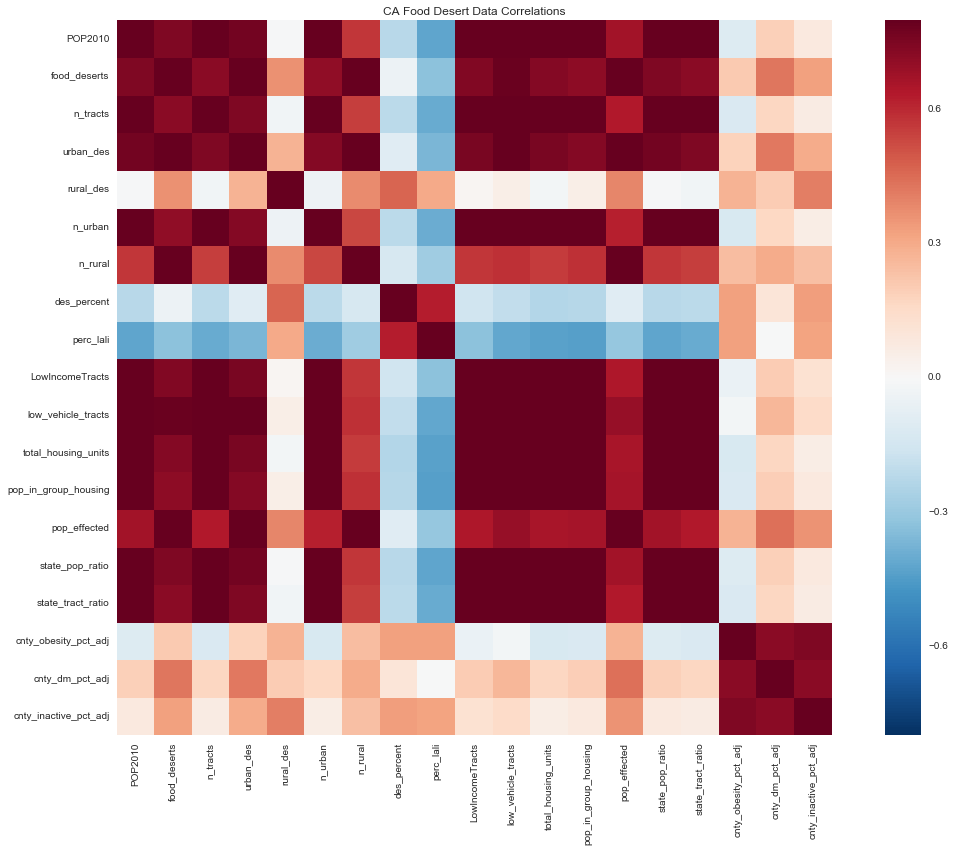

In [61]:
corrmat = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

In [63]:
df['rural_des'].describe()

count    58.000000
mean      0.862069
std       1.330457
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       5.000000
Name: rural_des, dtype: float64

Since we have organized our data by county, lets continue to do so by summing are food desert variables over the county level. 

In [42]:
# #df[df[~ county_df.columns.tolist()]]
# df[[col for col in df.columns.tolist() if col not in county_df.columns.tolist()]]
# county_sums = df[['County','POP2010', 'OHU2010', 'NUMGQTRS', 'HUNVFlag']].groupby('County').sum()
# county_sums = county_sums.reset_index()
# county_sums
# county_df = df.drop(['CensusTract','POP2010', 'OHU2010', 'NUMGQTRS', 'HUNVFlag','State'],axis=1 )
# county_df=county_df.groupby('County').agg(np.mean)
# county_df=county_df.reset_index()
# df = pd.merge(county_df,county_sums,how='inner',on='County')

In [43]:
# corrmat = df.corr()

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(16, 12))

# # Draw the heatmap using seaborn, and add a title to the plot
# sns.heatmap(corrmat, vmax=.8, square=True)
# ax.set_title('CA Food Desert Data Correlations')
# f.tight_layout()

In [44]:
len(df['County'].unique())
#df=df.drop('index',axis=1)


58

## Adding Features from Disparate Sources
Ok, now for the fun part! Let's add some interesting features that may be useful for our analysis.  First lets add some county level adolescent birth statistics. This data can be found at: http://www.healthdata.gov/dataset/adolescent-births-2010-2012. The cell below will add the number of adolescent births and the adolescent birth rate to our dataset.

In [65]:
#http://www.healthdata.gov/dataset/adolescent-births-2010-2012
#This dataset contains three indicators concerning births among adolescents aged 15-19: (1) Adolescent Birth Rate (ABR); (2) Percentage of Repeat Birth (PRB); and (3) Percentage of Births in High Poverty Area (PBHP).
births = pd.read_csv('/Users/desert/downloads/Adolescent_Births_2010-2012.csv')
births = births[(births['Race_ethnicity']=='ALL') & (births['Indicator']=='ABR')]
births = births[['MSSA_ID','COUNTY', 'Population','Adolescent_births','Indicator_rate']]
birth_sums=births.groupby('COUNTY').sum()
birth_sums=birth_sums.drop(['Indicator_rate','Population'],axis=1).fillna(0)
birth_sums = birth_sums.reset_index()
birth_rate=births.groupby('COUNTY').agg(np.mean)['Indicator_rate']
birth_rate=birth_rate.reset_index().fillna(0)
births = pd.merge(birth_sums,birth_rate,how='inner',on='COUNTY')
births.columns = ['County','Adolescent_births','ABR']

df = pd.merge(df,births,how='inner',on='County')
len(df['County'].unique())

58

In [68]:
df['ABR'] = df['ABR'] / 100
df.head()

,State,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,...,total_housing_units,pop_in_group_housing,pop_effected,state_pop_ratio,state_tract_ratio,cnty_obesity_pct_adj,cnty_dm_pct_adj,cnty_inactive_pct_adj,Adolescent_births,ABR
0,CA,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,...,545138,37442.0,27233,0.040540,0.044865,0.204,0.078,0.161,2765.0,0.180938
1,CA,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,...,497,24.0,313,0.000032,0.000125,0.232,0.077,0.173,0.0,0.000000
2,CA,Amador,38091,0,9,0.0,0.0,0,9,0.000000,...,14569,4551.0,5695,0.001022,0.001122,0.228,0.075,0.158,55.0,0.190000
3,CA,Butte,220000,14,51,13.0,1.0,38,13,0.274510,...,87618,4942.0,32028,0.005905,0.006356,0.243,0.073,0.163,590.0,0.238875
4,CA,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,...,18886,493.0,9268,0.001223,0.001246,0.253,0.067,0.161,73.0,0.177000


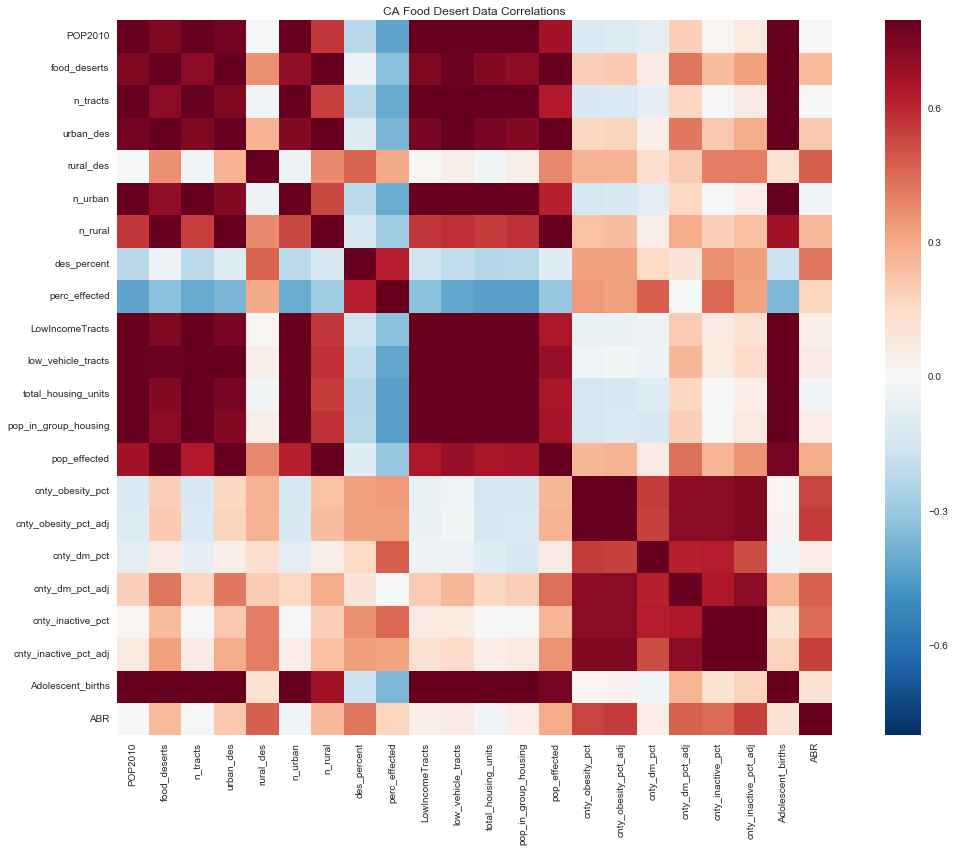

In [46]:
corrmat = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

Now lets add county education statistics.

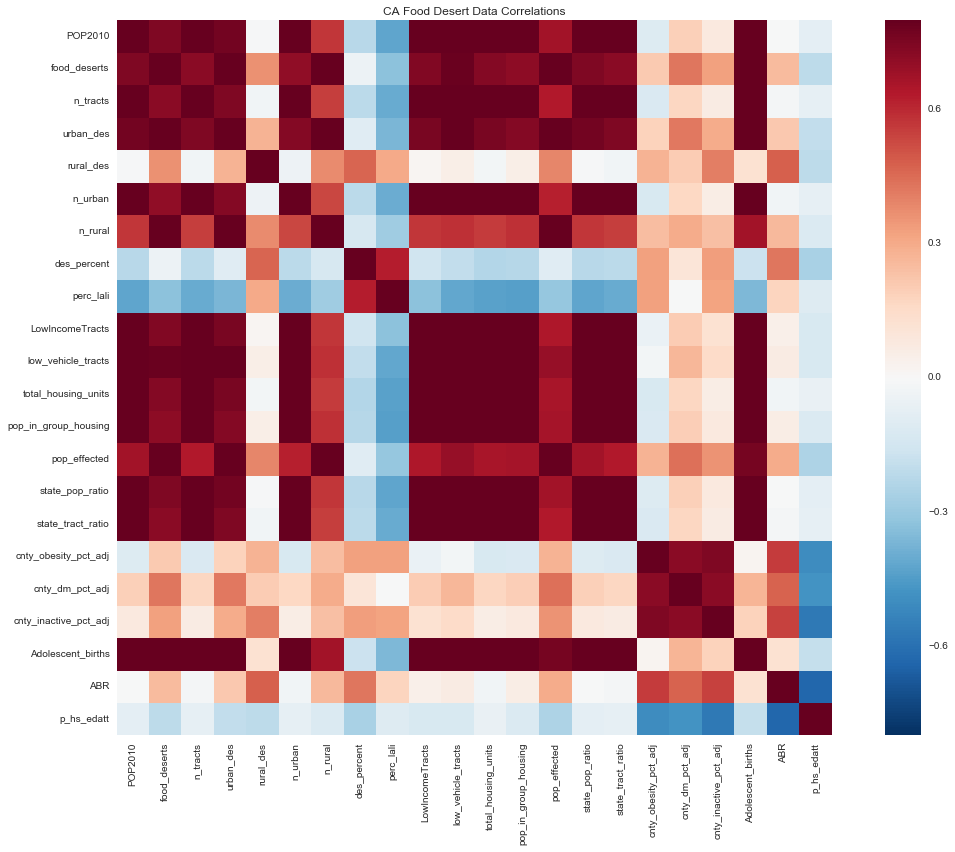

In [71]:
education=pd.read_csv('/Users/workspace/food_desert_data/Educational_Attainment__2000-2010.csv')
education=education[['county_name','p_hs_edatt']]
Xm=education['p_hs_edatt'].values
education = education.fillna(education.mean())

education.columns = ['County','p_hs_edatt']
education['p_hs_edatt'] = education['p_hs_edatt'] / 100

df = pd.merge(df,education,how='inner',on='County')
corrmat = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

Next, we will add county level demographic data (age, ethnicity) and the number of primary care providers, dentists, and psychiatrists practicing within each county. Data obtained from 
https://chhs.data.ca.gov/Demographics/Medical-Service-Study-Areas-2010/s6uk-kn8j

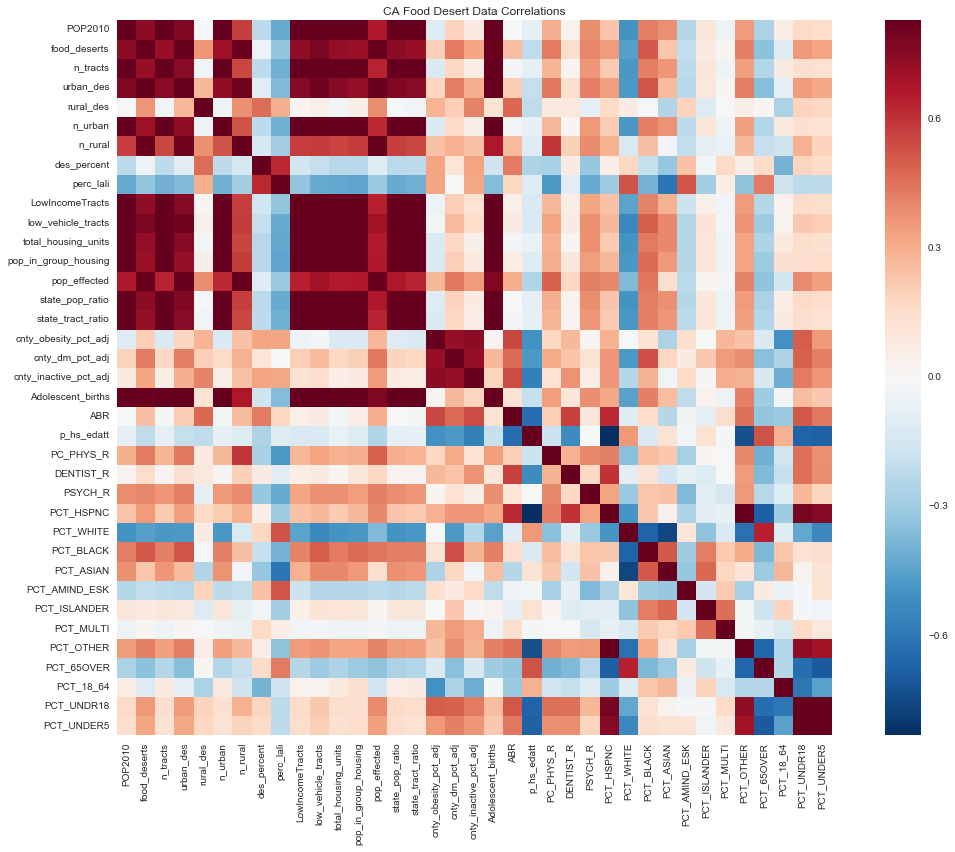

In [79]:
locations=pd.read_csv('/Users/desert/desert_workspace/desert_data/Medical_Service_Study_Areas__2010.csv')

locations.rename(columns={'COUNTY':'County'}, inplace=True)
locations.rename(columns={'UNIT_COUNT':'n_tracts_in_MSSA'}, inplace=True)
#locations=locations.drop('County', axis=1)
locations.columns.tolist()
loc_sums=locations[['County', 'PC_PHYS','DENTIST','PSYCH','HISPANIC',
           'WHITE','BLACK','ASIAN','AMIND_ESK','ISLANDER','MULTI_RACE',
           'OTHER_RACE','AGE_65OVER','AGE_18_64','AGE_UNDR18','AGE_UNDER5']].groupby('County').sum()
loc_avg=locations[['County', 'PC_PHYS_R','DENTIST_R','PSYCH_R','PCT_HSPNC',
           'PCT_WHITE','PCT_BLACK','PCT_ASIAN','PCT_AMIND_ESK','PCT_ISLANDER','PCT_MULTI',
           'PCT_OTHER','PCT_65OVER','PCT_18_64','PCT_UNDR18','PCT_UNDER5']].groupby('County').agg(np.mean)
loc_avg = loc_avg.reset_index()
len(loc_avg['County'].unique())
loc_sums= loc_sums.reset_index()
demo = loc_avg.columns.tolist()[4:]
loc_avg[demo]  = loc_avg[demo] / 100
loc_avg
df = pd.merge(df,loc_avg,how='inner',on='County')
corrmat = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

Below we make the variable 'des_percent,' which describes the percentage of county census tracts that are considered to be food deserts. 

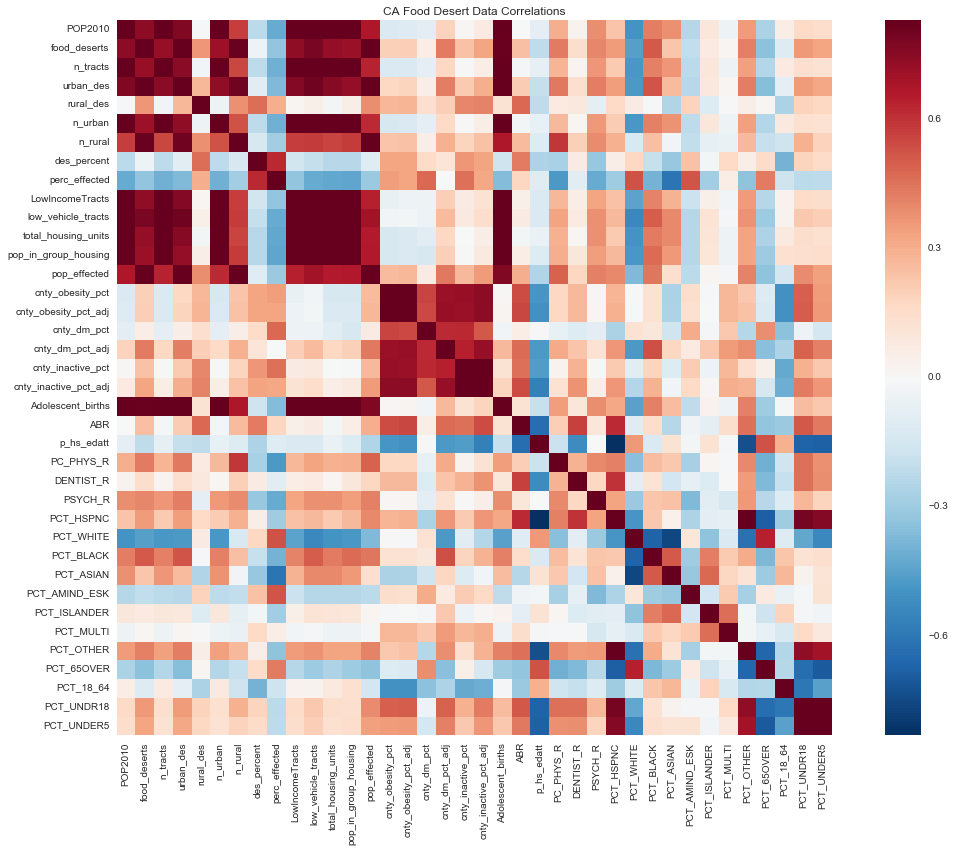

In [49]:
#df['des_percent'] = df['n_food_des'] / df['num_tracts']
#df['des_percent'].describe()
len(df)
corrmat = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

Next we add unemployment rates to our dataset. This is done by aggregating census tract level unemployment rates by county. These county averages are then merged with our dataset by executing the cell below. Data obtained from http://www.healthdata.gov/dataset/unemployment-2004-2013

In [81]:
unem = pd.read_csv('/Users/workspace/food_desert_data/Unemployment_2004-2013.csv', usecols=["reportyear", "geotypevalue", "county_name","race_eth_name", "Unemployment_rate"])
unem=unem.dropna()
unem[unem['reportyear'] == '2006-2010']
unem.rename(columns={'geotypevalue':'CensusTract'}, inplace=True)
unem=unem.groupby(['county_name','race_eth_name']).agg(np.mean).reset_index()
unem=unem[unem['race_eth_name'] == 'Total']
len(unem['county_name'].unique())
unem=unem[['county_name','Unemployment_rate']]
unem.columns=['County','unemployment_rate']
unem['unemployment_rate']=unem['unemployment_rate']/100
df = pd.merge(df,unem,how='inner',on='County')

In [82]:
df.head()

,State,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,...,PCT_ASIAN,PCT_AMIND_ESK,PCT_ISLANDER,PCT_MULTI,PCT_OTHER,PCT_65OVER,PCT_18_64,PCT_UNDR18,PCT_UNDER5,unemployment_rate
0,CA,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,...,0.277825,0.015906,0.011956,0.046631,0.099725,0.107956,0.662819,0.229206,0.065300,0.082085
1,CA,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,...,0.040800,0.271300,0.000000,0.045100,0.040000,0.098600,0.640300,0.261100,0.094400,0.116692
2,CA,Amador,38091,0,9,0.0,0.0,0,9,0.000000,...,0.015467,0.030900,0.003633,0.040100,0.034900,0.214533,0.621700,0.163800,0.032933,0.110562
3,CA,Butte,220000,14,51,13.0,1.0,38,13,0.274510,...,0.036288,0.042937,0.006088,0.049500,0.050388,0.154550,0.615138,0.230325,0.053037,0.112294
4,CA,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,...,0.016800,0.033900,0.001500,0.026400,0.023700,0.200300,0.599200,0.200500,0.041400,0.081250


Next we add county hospital readmission and death rates to our dataset. This data can be found at:
http://catalog.data.gov/dataset/readmissions-and-deaths-hospital/resource/07511388-4460-4141-a6d5-407e0dda0dd9

"The readmission measures are estimates of unplanned readmission to an acute care hospital in the 30 days after discharge from a hospitalization. Patients may have had an unplanned readmission for any reason.



The death (mortality) measures are estimates of deaths in the 30 days after either:

Entering the hospital for a specific condition; or
Having a coronary artery bypass graft (CABG) surgery.
Deaths can be for any reason, and can occur in the hospital or after discharge.


Readmission and death rates are measured within 30 days, because readmissions and deaths after a longer time period may have less to do with the care gotten in the hospital and more to do with other complicating illnesses, patients’ own behavior, or care provided to patients after hospital discharge." (https://www.medicare.gov/hospitalcompare/Data/30-day-measures.html)

https://www.medicare.gov/hospitalCompare/Data/data-updated.html#MG17

In [102]:
hospital = pd.read_csv('/Users/workspace/PycharmProjects/desert/desert_data/Readmissions_and_Deaths_-_Hospital.csv')
ids = list(hospital['Measure ID'].unique())
ids =[x.lower() for x in ids] 
num_hosp=hospital.groupby('County Name').count()['Provider ID'].reset_index()
num_hosp['County Name']=[x.title() for x in num_hosp['County Name'] ]
#num_hosp.columns = ['County', 'n_hospitals']
num_hosp
hospital = hospital[hospital['Score'] != 'Not Available']
hospital = hospital.apply(lambda x: pd.to_numeric(x, errors='ignore'))  # Convert columns to numeric where possible
hospital['County Name']=[x.title() for x in hospital['County Name'] ]
hospital=hospital.groupby(['County Name','Measure ID']).agg(np.mean)['Score'].reset_index()

hospital["Score"] = hospital.groupby(['County Name','Measure ID']).transform(lambda x: x.fillna(x.mean()))
hospital["Score"] = hospital['Score'] / 100
hospital=hospital.pivot(index='County Name', columns='Measure ID', values='Score')#.reset_index()
hospital.columns = ids
hospital=hospital.reset_index()
hospital = pd.merge(num_hosp, hospital, how='inner', on='County Name')
hospital.rename(columns={'County Name':'County', 'Provider ID' : 'n_hospitals'}, inplace=True)
#hospital[hospital == 0].dropna(axis=0) #.count()
hospital = hospital.fillna(0.0)
len(hospital['County'].unique())
[c for c in df.County.values if c not in hospital['County'].unique()]
df = pd.merge(df,hospital,how='left',on='County')
df = df.fillna(0)
df.head()

,State,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,...,mort_30_pn,mort_30_stk,readm_30_ami,readm_30_cabg,readm_30_copd,readm_30_hf,readm_30_hip_knee,readm_30_hosp_wide,readm_30_pn,readm_30_stk
0,CA,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,...,0.114444,0.138111,0.178250,0.153,0.205778,0.22600,0.048571,0.154727,0.178778,0.134500
1,CA,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,...,0.000000,0.000000,0.000000,0.000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,CA,Amador,38091,0,9,0.0,0.0,0,9,0.000000,...,0.125000,0.171000,0.000000,0.000,0.206000,0.21900,0.049000,0.150000,0.157000,0.114000
3,CA,Butte,220000,14,51,13.0,1.0,38,13,0.274510,...,0.109750,0.133667,0.165667,0.146,0.216250,0.22475,0.054333,0.162250,0.178750,0.127667
4,CA,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,...,0.109000,0.146000,0.000000,0.000,0.208000,0.22300,0.048000,0.157000,0.166000,0.144000


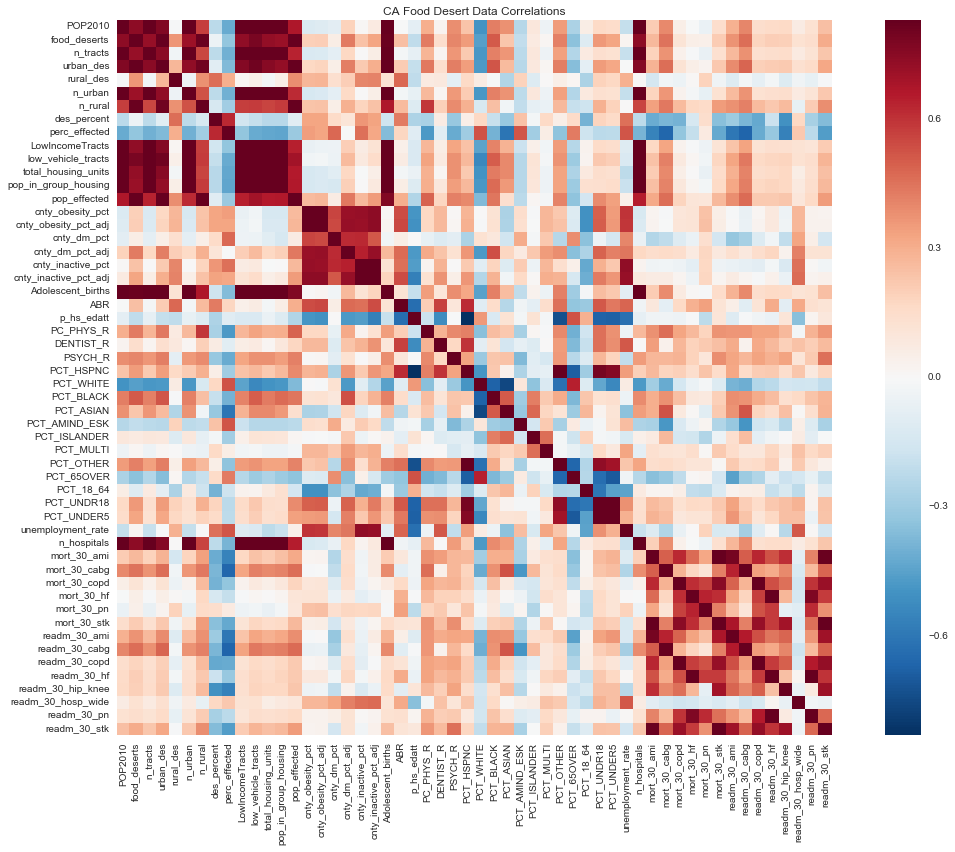

In [52]:
corrmat = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

Infection Rates: 
The rate of disease per 100,000 population for the corresponding County, Year, Sex strata using the standard calculation (Count *100,000/Population)
Data obtained from http://www.healthdata.gov/dataset/infectious-disease-cases-county-year-and-sex-2001-2014

In [139]:
inf = pd.read_csv('/Users/workspace/food_desert_data/Infectious_Disease_Cases_by_County__Year__and_Sex__2001-2014.csv')
inf = inf[(inf['Year'] == 2010) & (inf['County']!='California')]
inf = inf[inf['Sex'] == 'Total']
inf.columns.tolist()
inf


grouped=inf.groupby(['County','Disease']).agg(np.mean)[['Count', 'Rate']].reset_index()
grouped
inf_counts=grouped.pivot(index='County', columns='Disease', values='Count').reset_index()
inf_counts
#grouped
inf_rates=grouped.pivot(index='County', columns='Disease', values='Count').reset_index()
inf_rates
grouped
inf_rates.columns.tolist()#[['County','Tuberculosis']]
inf_rates=inf_rates[['County','Chlamydia','Tuberculosis', 'Gonorrhea','HIV','Influenza Death (<65 years of age)', 'Measles','Mumps', 'Pertussis','Rubella','Varicella Hospitalizations','Salmonellosis', 'E. coli O157','E. coli Other STEC (non-O157)','Early Syphilis','Botulism, Foodborne']]
inf_data_dict = pd.read_excel('/Users/workspace/food_desert_data/CID-Cases-by-Disease-County-Year-Sex-DATA-DICTIONARY.xlsx')
inf_data_dict['DEFINITION AND VALUES'][6]
len(inf_rates['County'].unique())
#inf_rates.info(verbose=True)
inf_rates
inf_rates.rename(columns={'Influenza Death (<65 years of age)':'senior_flu_deaths'}, inplace=True)
inf_rates.rename(columns={'Varicella Hospitalizations':'varicella_hospitalizations'}, inplace=True)
inf_rates.rename(columns={'E. coli O157':'ecoli_hem'}, inplace=True)
inf_rates.rename(columns={'E. coli Other STEC (non-O157)':'ecoli_nonhem'}, inplace=True)
inf_rates.rename(columns={'Early Syphilis':'syphilis'}, inplace=True)
inf_rates.rename(columns={'Botulism, Foodborne':'botulism_dtfood'}, inplace=True)
inf_rates.columns.tolist()
std=['Chlamydia','Gonorrhea','HIV','syphilis']
vaccine = ['Tuberculosis', 'senior_flu_deaths', 'Measles', 'Mumps', 'Pertussis', 'Rubella', 'varicella_hospitalizations']
food = ['Salmonellosis','ecoli_hem','ecoli_nonhem','syphilis','botulism_dtfood']
inf_rates['std'] = inf_rates[std].sum(axis=1)
inf_rates['vaccine_dx'] = inf_rates[vaccine].sum(axis=1)
inf_rates['food_dx'] = inf_rates[food].sum(axis=1)
inf_rates 
#grouped
#inf_rates[inf_rates.columns.tolist()[1:]] = inf_rates[inf_rates.columns.tolist()[1:]]
#100000 / df['POP2010']
df = pd.merge(df,inf_rates,how='inner',on='County')
df.head(2)

,State,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,...,Rubella,varicella_hospitalizations,Salmonellosis,ecoli_hem,ecoli_nonhem,syphilis,botulism_dtfood,std,vaccine_dx,food_dx
0,CA,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,...,0,2,257,14,4,172,0,9362,629,447
1,CA,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [147]:
infx = inf_rates.columns.tolist()[1:]
#*100,000/Population
for c in infx:
    df[c] = df[c] / df['POP2010']  * 100000
df.head()

,State,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,...,Rubella,varicella_hospitalizations,Salmonellosis,ecoli_hem,ecoli_nonhem,syphilis,botulism_dtfood,std,vaccine_dx,food_dx
0,CA,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,...,0.0,0.132427,17.016814,0.926986,0.264853,11.388685,0.0,619.888748,41.648155,29.597337
1,CA,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2,CA,Amador,38091,0,9,0.0,0.0,0,9,0.000000,...,0.0,0.000000,7.875876,0.000000,2.625292,2.625292,0.0,199.522197,15.751752,13.126460
3,CA,Butte,220000,14,51,13.0,1.0,38,13,0.274510,...,0.0,0.454545,25.909091,1.363636,0.000000,0.454545,0.0,395.000000,15.909091,27.727273
4,CA,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,...,0.0,0.000000,8.776164,2.194041,0.000000,0.000000,0.0,120.672254,19.746369,10.970205


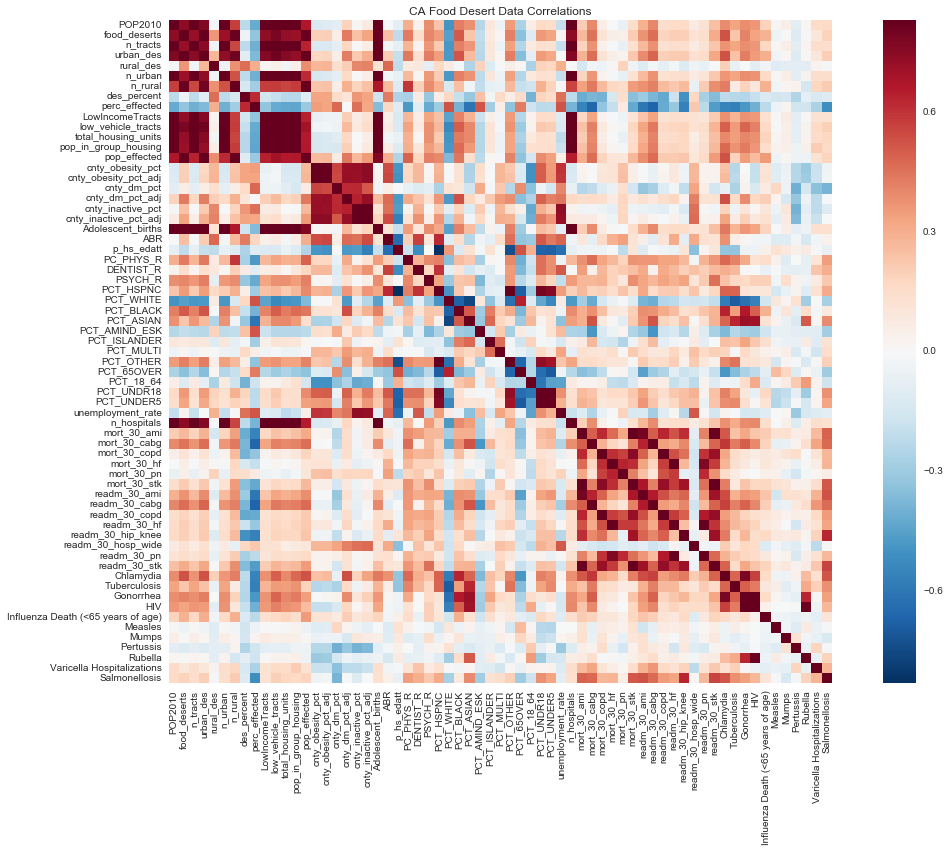

In [56]:
corrmat = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Draw the heatmap using seaborn, and add a title to the plot
sns.heatmap(corrmat, vmax=.8, square=True)
ax.set_title('CA Food Desert Data Correlations')
f.tight_layout()

Below adds county level opiod prescription data to our orignial dataset. Data can be found at http://www.chcf.org/oscn/data

number of opiod rx filled / 2010 county pop x 100000
does not include bupe

In [149]:
op = pd.read_excel('/Users/desert/desert_workspace/desert_data/OpioidSafetyData/Prescription_Data_byCounty_2010-13_OpioidSafetyCoalitions_run041216.xlsx', sheet=1)
op.head()
op=op[['County','2010 \n# of opioid prescriptions per 1000 residents per year \n(excl bupe)']]
op
op.columns = ['County', 'opiods_rx_1000']
op['opiods_greater_than_stateavg'] = op['opiods_rx_1000'] > 598
op['opiods_greater_than_stateavg'] = op['opiods_greater_than_stateavg'].astype(int)
mask = op['County'].isin(df['County'])
op = op[mask]
df = pd.merge(df,op,how='inner',on='County')
df.head()

,State,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,...,Salmonellosis,ecoli_hem,ecoli_nonhem,syphilis,botulism_dtfood,std,vaccine_dx,food_dx,opiods_rx_1000,opiods_greater_than_stateavg
0,CA,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,...,17.016814,0.926986,0.264853,11.388685,0.0,619.888748,41.648155,29.597337,557.20,0
1,CA,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,578.68,0
2,CA,Amador,38091,0,9,0.0,0.0,0,9,0.000000,...,7.875876,0.000000,2.625292,2.625292,0.0,199.522197,15.751752,13.126460,1244.76,1
3,CA,Butte,220000,14,51,13.0,1.0,38,13,0.274510,...,25.909091,1.363636,0.000000,0.454545,0.0,395.000000,15.909091,27.727273,1389.20,1
4,CA,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,...,8.776164,2.194041,0.000000,0.000000,0.0,120.672254,19.746369,10.970205,1068.98,1


In [150]:
acc=pd.read_excel('/Users/desert/downloads/DataDownload.xls',sheetname=1)
acc
acc[acc['Variable Code'] == 'FFR12']
acc[acc['Variable Code'] == 'PCH_FFR_07_12']

,Category,Category Code,Sub Category,Variable Name,Variable Code,Geography,Units
48,Restaurant Availability and Expenditures,RESTAURANTS,Fast-food,"Fast-food restaurants (% change), 2007-12",PCH_FFR_07_12,CNTY10,% change


Below adds the average price of milk and soda in each county to our dataset.

In [151]:
acc['Category Code'].unique()
#acc[acc['Category Code']=='PRICES_TAXES']
#acc[acc['Category Code']=='ASSISTANCE']
#acc[acc['Category Code']=='LOCAL']
#acc[acc['Category Code']=='INSECURITY']
#acc[acc['Category Code']=='ACCESS']
#acc[acc['Category Code']=='STORES']
tax=pd.read_excel('/Users/desert/downloads/DataDownload.xls',sheetname=9)
tax=tax[['State','County','MILK_PRICE10','SODA_PRICE10','MILK_SODA_PRICE10']]
tax= tax[tax['State']=='CA']
tax=tax.drop('State',axis=1)
tax.head()
df = pd.merge(df,tax,how='inner',on='County')

Below adds the number of fast food restraunts in each county for 2007 and 2012, as well as the percentage of growth or reduction in fast food restraunts. 

In [152]:
#acc_df=pd.read_excel('/Users/desert/downloads/DataDownload.xls',sheetname=9)
acc_df=pd.read_excel('/Users/desert/downloads/DataDownload.xls',sheetname=10)
acc_df = acc_df[acc_df['State'] == 'CA']
acc_df=acc_df[['County','PCH_FFR_07_12','FFR07','FFR12']]
acc_df


df=pd.merge(df,acc_df, how='inner',on='County')
df

,State,County,POP2010,food_deserts,n_tracts,urban_des,rural_des,n_urban,n_rural,des_percent,...,vaccine_dx,food_dx,opiods_rx_1000,opiods_greater_than_stateavg,MILK_PRICE10,SODA_PRICE10,MILK_SODA_PRICE10,PCH_FFR_07_12,FFR07,FFR12
0,CA,Alameda,1510271,15,360,15.0,0.0,354,6,0.041667,...,41.648155,29.597337,557.20,0,1.122215,1.164422,0.891575,8.902878,1112.0,1211
1,CA,Alpine,1175,0,1,0.0,0.0,0,1,0.000000,...,0.000000,0.000000,578.68,0,1.032918,1.089488,0.877073,-50.000000,2.0,1
2,CA,Amador,38091,0,9,0.0,0.0,0,9,0.000000,...,15.751752,13.126460,1244.76,1,1.032918,1.089488,0.877073,-5.555556,18.0,17
3,CA,Butte,220000,14,51,13.0,1.0,38,13,0.274510,...,15.909091,27.727273,1389.20,1,0.996443,1.130546,0.815374,2.684564,149.0,153
4,CA,Calaveras,45578,0,10,0.0,0.0,2,8,0.000000,...,19.746369,10.970205,1068.98,1,1.032918,1.089488,0.877073,-7.407407,27.0,25
5,CA,Colusa,21419,1,5,1.0,0.0,2,3,0.200000,...,65.362529,4.668752,836.42,1,1.032918,1.089488,0.877073,-16.666667,12.0,10
6,CA,Contra Costa,1049025,15,207,15.0,0.0,202,5,0.072464,...,22.878387,20.209242,767.82,1,1.122215,1.164422,0.891575,1.768489,622.0,633
7,CA,Del Norte,28610,3,7,2.0,1.0,4,3,0.428571,...,55.924502,0.000000,1604.28,1,0.996443,1.130546,0.815374,-21.428571,14.0,11
8,CA,El Dorado,181058,3,42,2.0,1.0,20,22,0.071429,...,30.377006,14.360039,1066.12,1,1.032918,1.089488,0.877073,-15.966387,119.0,100
9,CA,Fresno,930450,31,199,26.0,5.0,170,29,0.155779,...,65.237251,18.808104,635.82,1,0.996443,1.130546,0.815374,6.099815,541.0,574


Now that we have added all the data we need, we can now start to explore our dataset. 


## Getting a Sense of the Data with Initial EDA



In [62]:
slim = [col for col in df.columns.tolist() if col not in inf_rates.columns.tolist()]
slim.append('County')

sub = df[slim]

def order(frame,var):
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

#sub=order(sub,['County','LILATracts_1And10','high_food_des_prev'])

### Correlation 
In statistics, there is a measure that helps to measure how (in the sense of how much and in what direction) two variables relate to each other: correlation.
In correlation, a few steps are to be considered. First, your variables have to be standardized (or your result won't be a correlation but a covariation, a measure of association that is affected by the scale of the variables you are working with).
  
In statistical Z score standardization, you subtract from each variable its mean and then you divide the result by the standard deviation. The resulting transformed variable will have a mean of 0 and a standard deviation of 1 (or unit variance, since variance is the squared standard deviation).


In [65]:
from scipy.stats.stats import pearsonr

def covariance(variable_1, variable_2, bias=0):
    observations = float(len(variable_1))
    return np.sum((variable_1 - np.mean(variable_1)) * (variable_2 - np.mean(variable_2)))/(observations-min(bias,1))

def standardize(variable):
    return (variable - np.mean(variable)) / np.std(variable)

def correlation(var1,var2,bias=0):
    return covariance(standardize(var1), standardize(var2),bias)

print ('Our correlation estimation: %0.5f' %
(correlation(df['des_percent'], df['Tuberculosis'])))
print ('Correlation from Scipy pearsonr estimation: %0.5f' %
pearsonr(df['des_percent'], df['Tuberculosis'])[0])
#standardize(county_df['LILATracts_1And10']).describe()

Our correlation estimation: -0.23113
Correlation from Scipy pearsonr estimation: -0.23113


In [66]:
ids

['mort_30_ami',
 'mort_30_cabg',
 'mort_30_copd',
 'mort_30_hf',
 'mort_30_pn',
 'mort_30_stk',
 'readm_30_ami',
 'readm_30_cabg',
 'readm_30_copd',
 'readm_30_hf',
 'readm_30_hip_knee',
 'readm_30_hosp_wide',
 'readm_30_pn',
 'readm_30_stk']

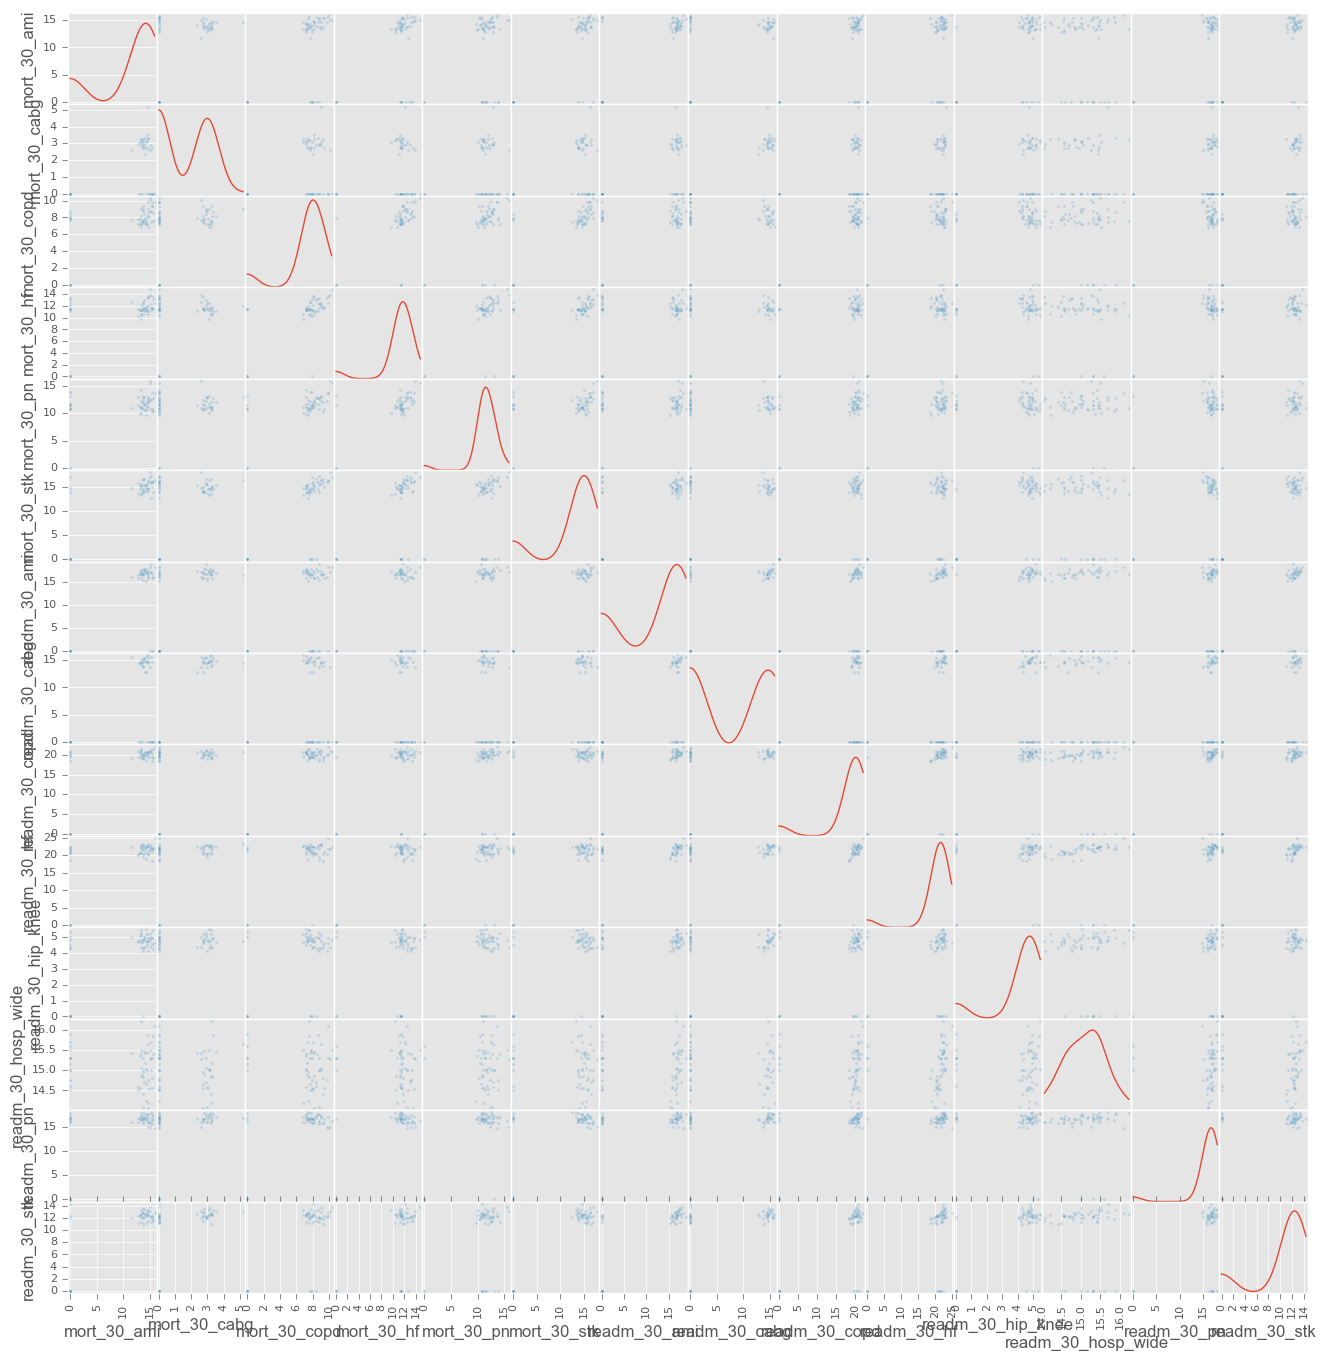

In [67]:
sns.reset_orig()
plt.style.use('ggplot')

pplot = pd.scatter_matrix(df[ids].dropna(), figsize=(16, 16), alpha=0.2, diagonal='kde')

In [153]:
df.to_csv('/Users/desert/desert_workspace/desert_data/fd_data.csv')

In [ ]:
# sns.reset_orig()
# plt.style.use('ggplot')
df.info(verbose=True)
df = df.fillna(0)
#pplot = pd.scatter_matrix(sub, figsize=(16, 16), alpha=0.2, diagonal='kde')

In [ ]:
df.info(verbose=True)

Before saving our dataset, we should also obtain the number citizens that are living in food deserts in each county. Up until this point, most of the features we have obtained focus on which counties have the most food deserts, but do not account for population sizes. By determining how many individuals are effected by food deserts, we can better assess what counties are the most impacted by this issue, and ask more interesting questions.

In [ ]:
pops=pd.read_excel('/Users/workspace/PycharmProjects/desert/desert_data/food_desert.xlsx',sheetname=2)
cols = pops.columns.tolist()

In [ ]:
subset = ['CensusTract','State','County','POP2010','Rural','Urban','LILATracts_1And10']
pops = pops[pops['State']=='CA']
pops=pops[subset]
grouped = pops[['County','POP2010','Rural','Urban','LILATracts_1And10']].groupby(['County','LILATracts_1And10']).sum()
grouped = grouped.reset_index()
deserts = grouped[grouped['LILATracts_1And10']==1]
deserts=deserts[['County','POP2010']]
deserts.columns = ['County','pop2010_in_des']
deserts.head()

In [ ]:
df = pd.merge(df,deserts,how='left', on='County')
df.head()

Let's save our dataset to a csv. This will allow us to access our cleaned county level dataset in the next notebook where we will explore what features are related to food deserts. 

In [ ]:
df.columns.tolist()

In [ ]:
df.to_csv('/Users/desert/desert_workspace/desert_data/clean_data.csv')

In [ ]:
import pymc as pm
from IPython.core.pylabtools import figsize

figsize(12, 4)

# these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

# notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

# generate some observations
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print "Obs from Site A: ", observations_A[:30].astype(int), "..."
print "Obs from Site B: ", observations_B[:30].astype(int), "..."

In [ ]:

print observations_A.mean()
print observations_B.mean()

In [ ]:
sub = df[slim]
sub=order(sub,['County','LILATracts_1And10','high_food_des_prev'])
sub.columns
bayes = sub[['County','num_tracts','Urban','n_food_des','POP2010','cnty_obesity_pct','LILATracts_1And10','high_food_des_prev']]
bayes =bayes.set_index('County')

# bayes_norm = (bayes - bayes.min()) / (bayes.max() - bayes.min())
# bayes_norm['prev']=bayes_norm['n_food_des'] / bayes_norm['num_tracts']
# bayes_norm.describe()
# bayes_norm[bayes_norm['prev'] >= 9.007692]
#test = bayes_norm[bayes_norm['prev'] >= 9.007692].index#3.095655
# sub = sub.set_index('County')
# sub.loc[test]
#bayes_norm.index

test = bayes.apply(standardize)#.describe()
#test.loc[test['n_food_des']<0,'n_food_des'] = 0
#test['prev']=test['LILATracts_1And10'] * test['num_tracts'] # ok to compare values on the same scale ?
#test#.describe()
test = test[test['LILATracts_1And10'] >= 0].index
sub = sub.set_index('County')
sub.loc[test]
corrmat = df.set_index('County').loc[test].corr()
corrmat=corrmat[(corrmat['LILATracts_1And10'] > .25 ) | (corrmat['LILATracts_1And10'] < -.25 )]
corrmat=corrmat.loc[corrmat.columns]
corrmat=corrmat['LILATracts_1And10'].dropna()
corrmat.plot(kind='bar')
# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(16, 12))

# # Draw the heatmap using seaborn, and add a title to the plot
# sns.heatmap(corrmat, vmax=.8, square=True)
# ax.set_title('CA Food Desert Data Correlations')
# f.tight_layout()

# bayes[bayes['high_food_des_prev'] ==1].describe()#72805
# bayes[bayes['high_food_des_prev'] ==0].describe()#746912.4

In [ ]:
df.head()
data = order(df,['LILATracts_1And10','num_tracts']).values
plt.scatter(data[:, 1], data[:, 0], alpha=0.5, c="#7A68A6")
plt.title("Food desert prev vs N Tracts")
plt.ylabel("Food desert prev")
plt.xlabel("number of tracts")
#plt.xlim(-100, 15e3)
#plt.ylim(-5, 105)

i_min = np.argmin(data[:, 0])
i_max = np.argmax(data[:, 0])

plt.scatter([data[i_min, 1], data[i_max, 1]],
            [data[i_min, 0], data[i_max, 0]],
            s=60, marker="o", facecolors="none",
            edgecolors="#A60628", linewidths=1.5,
            label="most extreme points")

plt.legend(scatterpoints=1);

In [ ]:
df.columns

In [ ]:
#upvotes = n_food_deserts
#downvotes = n_food_deserts - num_tracts
upvotes = df['n_food_des'].values
downvotes = df['num_tracts'].values -df['n_food_des'].values 
downvotes

def posterior_upvote_ratio(upvotes, downvotes, samples=20000):
    """
    This function accepts the number of upvotes and downvotes a particular comment received, 
    and the number of posterior samples to return to the user. Assumes a uniform prior.
    """
    N = upvotes + downvotes
    upvote_ratio = pm.Uniform("upvote_ratio", 0, 1)
    observations = pm.Binomial("obs", N, upvote_ratio, value=upvotes, observed=True)
    # do the fitting; first do a MAP as it is cheap and useful.
    map_ = pm.MAP([upvote_ratio, observations]).fit()
    mcmc = pm.MCMC([upvote_ratio, observations])
    mcmc.sample(samples, samples / 4)
    return mcmc.trace("upvote_ratio")[:]

posterior_upvote_ratio(upvotes, downvotes, samples=20000)
#downvotes

In [ ]:
data = df[['n_food_des','num_tracts','County']].values
figsize(11., 8)
posteriors = []
colours = ["#348ABD", "#A60628", "#7A68A6", "#467821", "#CF4457"] * 12
colours
for i in range(len(data)):
    j = data[i]
    #print j
    posteriors.append(posterior_upvote_ratio(j[0], j[1]))
    plt.hist(posteriors[i], bins=18, normed=True, alpha=.9,
             histtype="step", color=colours[i % 5], lw=3,
             label='(%d deserts:%d tracts)\n%s...' % (j[0], j[1], j[2]))
    plt.hist(posteriors[i], bins=18, normed=True, alpha=.2,
             histtype="stepfilled", color=colours[i], lw=3, )
#     plt.legend(loc="upper left")
#     plt.xlim(0, 1)
#     plt.title("Posterior distributions of food desert ratios on different counties");
#     plt.show()

#plt.legend(loc="upper left")
plt.xlim(0, 1)
plt.title("Posterior distributions of food desert ratios on different counties");

In [ ]:
# posteriors
# ordered_contents 
# lb
# df.head()
# df.to_csv('/Users/desert/desert_workspace/desert_data/clean_data.csv')

In [ ]:
df.head()

In [ ]:
def intervals(u, d):
    a = 1. + u
    b = 1. + d
    mu = a / (a + b)
    std_err = 1.65 * np.sqrt((a * b) / ((a + b) ** 2 * (a + b + 1.)))
    return (mu, std_err)
data[:, 0].astype(int)
print "Approximate lower bounds:"
posterior_mean, std_err = intervals(data[:, 0].astype(int), data[:, 1].astype(int))
lb = posterior_mean - std_err
print lb
print
print "Top 20 Sorted according to approximate lower bounds:"
print
order = np.argsort(-lb)
ordered_contents = []
label=[]
for i in order[:20]:
    ordered_contents.append(data[i])
    label.append(data[i,-1])
    print label
    #print votes[i, 0], votes[i, 1], contents[i]
    print "-------------"


In [ ]:
r_order
r_order = order[::-1][-40:]
plt.errorbar(posterior_mean[r_order], np.arange(len(r_order)),
             xerr=std_err[r_order], xuplims=True, capsize=0, fmt="o",
             color="#7A68A6")
# #plt.xlim(0.3, 1)
plt.yticks(np.arange(len(r_order) - 1, -1, -1)), data[r_order][:,-1].astype(list);
#zip(np.arange(len(r_order) - 1, -1, -1),data[r_order][:,-1].astype(list))
#np.arange((len(r_order) - 1), data[r_order][:,-1])#.astype(list))

In [ ]:
import pymc 

def linear_setup(df, ind_cols, dep_col):
    '''
        Inputs: pandas Data Frame, list of strings for the independent variables,
        single string for the dependent variable
        Output: PyMC Model
    '''
    
    # model our intercept and error term as above
    b0 = pymc.Normal("b0", 0, 0.0001)
    err = pymc.Uniform("err", 0, 500)
    
    # initialize a NumPy array to hold our betas 
    # and our observed x values
    b = np.empty(len(ind_cols), dtype=object)
    x = np.empty(len(ind_cols), dtype=object)
    
    # loop through b, and make our ith beta
    # a normal random variable, as in the single variable case
    for i in range(len(b)):
        b[i] = pymc.Normal("b" + str(i + 1), 0, 0.0001)
        
    # loop through x, and inform our model about the observed
    # x values that correspond to the ith position
    for i, col in enumerate(ind_cols):
        x[i] = pymc.Normal("x" + str(i + 1), 0, 1, value=np.array(df[col]), observed=True)
    
    # as above, but use .dot() for 2D array (i.e., matrix) multiplication
    @pymc.deterministic
    def y_pred(b0=b0, b=b, x=x):
        return b0 + b.dot(x)
    
    # finally, "model" our observed y values as above
    y = pymc.Normal("y", y_pred, err, value=np.array(df[dep_col]), observed=True)
    
    return pymc.Model([b0, pymc.Container(b), err, pymc.Container(x), y, y_pred])

test_model = linear_setup(df, ['PC_PHYS_R', "PCT_BLACK"], 'LILATracts_1And10')
mcmc = pymc.MCMC(test_model)
mcmc.sample(100000, 20000)

In [ ]:
multifig, multiax = plt.subplots(2, 1, figsize=(10, 10))
b_nought = mcmc.trace("b0")[:]
b_phys = mcmc.trace("b1")[:]
b_bl = mcmc.trace("b2")[:]

multiax[0].hist(b_phys)
multiax[0].set_title("MD ratio Coefficient Probability Distribution")
multiax[1].hist(b_bl)
multiax[1].set_title("Af-Amr Coefficient Probability Distribution")

In [ ]:
print "Intercept: " + str(np.mean(b_nought)) 
print "MD ratio Coefficient: " + str(np.mean(b_phys)) 
print "Af_amr Coefficient: " + str(np.mean(b_bl))


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# y = mssa['LA1and10']
# x = mssa
x = df[['PC_PHYS_R', "PCT_BLACK"]]
y =  df['LILATracts_1And10'].values

#mssa = order(mssa,['LILATracts_1And10'])
# X = county_df.copy(deep=False)
# X = X.drop(['LILATracts_1And20','LILATracts_halfAnd10','LILATracts_Vehicle','overall_des_percent','vehicle_des_percent','half_10_des_percent','1_10_des_percent','1_20_des_percent', 'County','urban_county_des','rural_county_des'],axis=1)
# X.dtypes
# y = county_df['LILATracts_1And10'].values
linear_regression = sm.OLS(y,x)
fitted_model = linear_regression.fit()
fitted_model.summary()


In [ ]:
df.columns.tolist()
df['PC_PHYS_R']
import scipy.stats as stats
figsize(12.5, 6)
from scipy.optimize import fmin


def stock_loss(price, pred, coef=500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price * pred < 0
    sol[ix] = coef * pred ** 2 - np.sign(price[ix]) * pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

tau_samples = mcmc.trace("prec")[:]
alpha_samples = mcmc.trace("alpha")[:]
beta_samples = mcmc.trace("beta")[:]

N = tau_samples.shape[0]

noise = 1. / np.sqrt(tau_samples) * np.random.randn(N)

possible_outcomes = lambda signal: alpha_samples + beta_samples * signal \
    + noise


opt_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
    _possible_outcomes = possible_outcomes(_signal)
    tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
    opt_predictions[i] = fmin(tomin, 0, disp=False)


plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_ * X + ls_intercept, label="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label="Bayes action prediction")
plt.legend(loc="upper left");

# figsize(12.5, 9)

# norm_pdf = stats.norm.pdf

# plt.subplot(311)
# x = np.linspace(0, 60000, 200)
# sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500),
#                        color="#348ABD", lw=3, alpha=0.6,
#                        label="historical total prices")
# p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
# plt.legend([p1], [sp1.get_label()])

# plt.subplot(312)
# x = np.linspace(0, 10000, 200)
# sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500),
#                        color="#A60628", lw=3, alpha=0.6,
#                        label="snowblower price guess")

# p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
# plt.legend([p2], [sp2.get_label()])

# plt.subplot(313)
# x = np.linspace(0, 25000, 200)
# sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
#                        color="#7A68A6", lw=3, alpha=0.6,
#                        label="Trip price guess")
# plt.autoscale(tight=True)
# p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
# plt.legend([p3], [sp3.get_label()]);

In [ ]:
sub
import pymc as pm
import numpy as np
from pymc.examples import disaster_model
switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=110)
switchpoint 

In [ ]:
import pymc as pm


parameter = pm.Exponential("poisson_param", 1)
data_generator = pm.Poisson("data_generator", parameter)
data_plus_one = data_generator + 1


In [ ]:
sns.distplot(county_df['cnty_obesity_pct'])
sns.distplot(county_df['LILATracts_1And10'])
county_pop = df[['County','POP2010']].groupby('County').agg(np.sum).reset_index()
county_df=pd.merge(county_df,county_pop,how='inner',on='County')

In [ ]:
county_df
import statsmodels.api as sm
import statsmodels.formula.api as smf

# y = mssa['LA1and10']
# x = mssa

#mssa = order(mssa,['LILATracts_1And10'])
X = county_df.copy(deep=False)
X = X.drop(['LILATracts_1And20','LILATracts_halfAnd10','LILATracts_Vehicle','overall_des_percent','vehicle_des_percent','half_10_des_percent','1_10_des_percent','1_20_des_percent', 'County','urban_county_des','rural_county_des'],axis=1)
X.dtypes
# y = county_df['LILATracts_1And10'].values
# linear_regression = sm.OLS(y,X)
# fitted_model = linear_regression.fit()
# fitted_model.summary()
X

In [ ]:
bayes = county_df[['POP2010','cnty_obesity_pct','cnty_dm_pct','cnty_inactive_pct','LILATracts_1And10','num_tracts']]
bayes['cnty_obesity_pct'] = bayes['cnty_obesity_pct'] * .01
bayes['cnty_dm_pct'] = bayes['cnty_dm_pct'] * .01
bayes['cnty_inactive_pct'] = bayes['cnty_inactive_pct'] * .01
bayes['obese'] = bayes['cnty_obesity_pct'] * bayes['POP2010']
bayes['dm'] = bayes['cnty_dm_pct'] * bayes['POP2010']

In [ ]:
# import pymc as pm

# p = pm.Uniform('p', lower=0, upper=1)
# p_true
n = bayes['POP2010']
conversions = bayes['obese']
prior = bayes['cnty_obesity_pct']

In [ ]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

# For the already prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials) / 2, 2, k + 1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials) - 1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14)

plt.tight_layout()